импортирую все необходимые инструменты

In [195]:
import numpy as np
import pandas as pd
import pickle

from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.image as img
import seaborn as sns
matplotlib.rcParams.update({'font.size':10})

* Описание датасета:
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [337]:
# функция для построение основных метрик и графиков для просмотра
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    # расчет метрических показателей для test и train
    print("Train R2:\t" + str(round(r2(train_true_values,train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values,test_pred_values), 3)))
    print("Train MAE:\t" + str(round(mae(train_true_values,train_pred_values), 3)))
    print("Test MAE:\t" + str(round(mae(test_true_values,test_pred_values), 3)))
    print("Train MSE:\t" + str(round(mse(train_true_values,train_pred_values), 3)))
    print("Test MSE:\t" + str(round(mse(test_true_values,test_pred_values), 3)))
    # и средние показатели для test и train
    print("Train MEAN:\t" + str(round(np.mean(train_true_values), 3)))
    print("Test MEAN:\t" + str(round(np.mean(test_true_values), 3)))
    
    print("Delta:\t" + str(round((r2(train_true_values,train_pred_values)-r2(test_true_values,test_pred_values))/r2(train_true_values,train_pred_values)*100, 3)))
    
    plt.figure(figsize=(9,5))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.plot([train_pred_values.min(),train_true_values.max()],
              [train_pred_values.min(),train_true_values.max()],
            color ="red", linestyle = ":", alpha = 0.35)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title("Train sample prediction")
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title("Test sample prediction")
    
    plt.show()

выгрузка данных и объединения тренировочного датасета и тестового

In [696]:
DATASET_PATH = "project_task/train.csv"
PREPARED_DATASET_PATH = "project_task/test.csv"

train_df = pd.read_csv(DATASET_PATH)
test_df = pd.read_csv(PREPARED_DATASET_PATH)

full_df = pd.concat([train_df,test_df],ignore_index=True)

full_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


преобразуем все ID в строковые типы 

In [697]:
full_df['Id']=full_df['Id'].astype(str)
full_df['DistrictId']=full_df['DistrictId'].astype(str)

In [698]:
full_df.shape

(15000, 20)

проверим DataSet на выбросы

In [699]:
full_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,10000.000000
mean,1.897000,56.360350,36.851792,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133,214138.857399
std,0.839229,20.423913,71.120183,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545,92872.293865
min,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


объекты у которых общая площадь ниже 10кв. м. и кол-во комнат равно 2, 
изменим общую площадь на среднюю площадь 2-х комнатных квартир

In [700]:
full_df.loc[(full_df['Square']<10)&(full_df['Rooms']==2),'Square']=full_df.loc[(full_df['Rooms']==2),'Square'].median()

объекты у которых общая площадь ниже 10кв. м. и кол-во комнат равно 3, 
изменим общую площадь на среднюю площадь 3-х комнатных квартир

In [701]:
full_df.loc[(full_df['Square']<10)&(full_df['Rooms']==3),'Square']=full_df.loc[(full_df['Rooms']==3),'Square'].median()

* объекты у которых общая площадь ниже 10кв. м., 
* изменим общую площадь на сумму минимальной площади и стандартного отклонения

In [702]:
full_df.loc[(full_df['Square']<10),'Square']=full_df['Square'].min()+full_df['Square'].std()

* у объектов с жилой площадью больше 90% общей площади, заменим жилую площадь на величину равную 90% общей площади

In [703]:
full_df.loc[(full_df['LifeSquare']>0.9*full_df['Square']),'LifeSquare']=\
0.9*full_df.loc[(full_df['LifeSquare']>0.9*full_df['Square']),'Square']

* объекты, у которых сумма жилой площади и площади кухни больше общей площади, 
* заменим площадь кухни на разность общей площади и жилой

In [704]:
full_df.loc[(full_df['LifeSquare']+full_df['KitchenSquare']>full_df['Square']),'KitchenSquare']=\
full_df.loc[(full_df['LifeSquare']+full_df['KitchenSquare']>full_df['Square']),'Square']-\
full_df.loc[(full_df['LifeSquare']+full_df['KitchenSquare']>full_df['Square']),'LifeSquare']

* объекты, у которых жилая площади равна NULL, 
* заменим на разность общей площади и площади кухни

In [705]:
full_df.loc[(full_df['LifeSquare'].isnull()),'LifeSquare'] =\
full_df.loc[(full_df['LifeSquare'].isnull()),'Square']-\
full_df.loc[(full_df['LifeSquare'].isnull()),'KitchenSquare']

 объекты, у которых кол-во комнат больше 5 и общая площадь меньше 61 кв. м., 
 заменим кол-во комнат на 2

In [706]:
full_df.loc[(full_df['Rooms']>5)&(full_df['Square']<61),'Rooms']=2

* объекты, у которых этаж больше, чем этажность дома,
* поменяем места этажность дома и этаж
#####!!!!!!!! отрабатывает со второй попытки!!!!!!!!!

In [708]:
full_df.loc[(full_df['Floor']>full_df['HouseFloor']),'Floor'],full_df.loc[(full_df['Floor']>full_df['HouseFloor']),'HouseFloor']=\
full_df.loc[(full_df['Floor']>full_df['HouseFloor']),'HouseFloor'],full_df.loc[(full_df['Floor']>full_df['HouseFloor']),'Floor']

* объекты, у которых этажность дома равна 0,
* поменяем на медианную этажность дома

In [709]:
full_df.loc[(full_df['HouseFloor']==0),'HouseFloor']=full_df['HouseFloor'].median()

* объект, у которого некорректно введен формат года постройки дома,
* заменим на первые четыре цифры, которые и являются годом постройки

In [710]:
full_df.loc[full_df['HouseYear']==20052011,'HouseYear']=2005

* объект, у которого год постройки дома больше 2020,
* заменим на 2020

In [711]:
full_df.loc[full_df['HouseYear']>2020,'HouseYear']=2020

* объекты, у которых показатель здравоохранения равен NULL,
* заменим на медианну

In [712]:
full_df.loc[full_df['Healthcare_1'].isnull(),'Healthcare_1']=full_df['Healthcare_1'].median()

проверим отсутствия пустых строк, кроме целевых

In [713]:
full_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Shops_2             0
Price            5000
dtype: int64

посмотрим распределение объектов по стоимости недвижимости

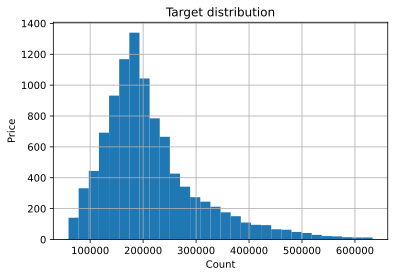

In [714]:
full_df['Price'].hist(bins=30)
plt.xlabel('Count')
plt.ylabel('Price')

plt.title('Target distribution')
plt.show()

определим столбцы, которые относятся к категориальным ('Id', 'DistrictId' - не относятся к категориям)

In [715]:
cat_colnames = full_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

посчитаем количество объектов в каждой категории основных столбцов

In [716]:
for cat_colnames in cat_colnames[2:]:
    print(str(cat_colnames)+'\n\n'+str(full_df[cat_colnames].value_counts())+'\n'+'*'*100+'\n')

Ecology_2

B    14855
A      145
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    14576
A      424
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    13763
A     1237
Name: Shops_2, dtype: int64
****************************************************************************************************



заменим значение категорий на бинарные признаки, для дальнейшего использования категорий в прогнозировании

In [717]:
full_df['Ecology_2_bin'] = full_df['Ecology_2'].replace({'A':0, 'B':1})
full_df['Ecology_3_bin'] = full_df['Ecology_3'].replace({'A':0, 'B':1})
full_df['Shops_2_bin'] = full_df['Shops_2'].replace({'A':0, 'B':1})

создадим новый столбец 'DistrictSize', в котором отраженом количество объектов в каждом 'DistrictId'

In [718]:
district_size = full_df['DistrictId'].value_counts().reset_index()\
    .rename(columns={'index':'DistrictId','DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,1242
1,1,996
2,23,829
3,6,768
4,9,426


и добавим его к нашему датасету

In [719]:
full_df = full_df.merge(district_size, on='DistrictId', how='left')
full_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.000000,7.0,9.0,1969,0.089040,...,5,900.0,0,11,B,184966.930730,1,1,1,36
1,15053,41,3.0,65.683640,40.049543,8.000000,7.0,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.450063,1,1,1,131
2,4765,53,2.0,44.947953,29.197612,0.000000,8.0,12.0,1968,0.049637,...,0,229.0,1,3,B,220925.908524,1,1,1,265
3,5809,58,2.0,53.352981,48.017683,5.335298,8.0,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,1,1,1,270
4,10783,99,1.0,39.649192,23.776169,7.000000,11.0,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,1,1,1,139


так же добавим бинарный флаг для каждого объекта, обозначающий его к отношение к району с количество квартир больше 100

In [720]:
full_df['isDistLarge'] = (full_df['DistrictSize']>100).astype(int)

In [721]:
full_df['PricePerSq']=round(full_df.loc[full_df['Price'].notnull(),'Price']/full_df.loc[full_df['Price'].notnull(),'Square'],2)

In [725]:
mean_price_per_sq_by_dist = full_df.groupby(['DistrictId','Rooms'], as_index=False).agg({'PricePerSq':'mean'})\
                        .rename(columns={'PricePerSq':'MedPricePerSqbyDist'})
full_df = full_df.merge(mean_price_per_sq_by_dist, on=['DistrictId','Rooms'], how = 'left')
full_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,isDistLarge,PricePerSq,MedPricePerSqbyDist
0,14038,35,2.0,47.981561,29.442751,6.000000,7.0,9.0,1969,0.089040,...,11,B,184966.930730,1,1,1,36,0,3854.96,4320.150000
1,15053,41,3.0,65.683640,40.049543,8.000000,7.0,9.0,1978,0.000070,...,16,B,300009.450063,1,1,1,131,1,4567.49,4143.131600
2,4765,53,2.0,44.947953,29.197612,0.000000,8.0,12.0,1968,0.049637,...,3,B,220925.908524,1,1,1,265,1,4915.15,4741.246883
3,5809,58,2.0,53.352981,48.017683,5.335298,8.0,17.0,1977,0.437885,...,5,B,175616.227217,1,1,1,270,1,3291.59,2962.604068
4,10783,99,1.0,39.649192,23.776169,7.000000,11.0,12.0,1976,0.012339,...,4,B,150226.531644,1,1,1,139,1,3788.89,4209.038333


In [728]:
full_df.isnull().sum()

Id                        0
DistrictId                0
Rooms                     0
Square                    0
LifeSquare                0
KitchenSquare             0
Floor                     0
HouseFloor                0
HouseYear                 0
Ecology_1                 0
Ecology_2                 0
Ecology_3                 0
Social_1                  0
Social_2                  0
Social_3                  0
Healthcare_1              0
Helthcare_2               0
Shops_1                   0
Shops_2                   0
Price                  5000
Ecology_2_bin             0
Ecology_3_bin             0
Shops_2_bin               0
DistrictSize              0
isDistLarge               0
PricePerSq             5000
MedPricePerSqbyDist       0
dtype: int64

* заполним пустые значения столбца mean_price_per_sq_by_dist средними значениями

In [727]:
full_df.loc[full_df['MedPricePerSqbyDist'].isnull(),'MedPricePerSqbyDist']=full_df['MedPricePerSqbyDist'].mean()

* посчитаем среднюю площадь квартир в завимисости от кол-ва комнат
* посчитаем на сколько отличается площадь текущего объекта от средней величины

In [729]:
gp = full_df.groupby(['Rooms'])['Square'].mean()
full_df['Mean_Sq_by_rooms'] = full_df['Rooms'].map(gp.to_dict())

full_df['Ratio_sq_mean_sq_by_rooms'] = full_df['Square']/full_df['Mean_Sq_by_rooms']-1
full_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,isDistLarge,PricePerSq,MedPricePerSqbyDist,Mean_Sq_by_rooms,Ratio_sq_mean_sq_by_rooms
0,14038,35,2.0,47.981561,29.442751,6.000000,7.0,9.0,1969,0.089040,...,184966.930730,1,1,1,36,0,3854.96,4320.150000,56.770028,-0.154808
1,15053,41,3.0,65.683640,40.049543,8.000000,7.0,9.0,1978,0.000070,...,300009.450063,1,1,1,131,1,4567.49,4143.131600,77.045196,-0.147466
2,4765,53,2.0,44.947953,29.197612,0.000000,8.0,12.0,1968,0.049637,...,220925.908524,1,1,1,265,1,4915.15,4741.246883,56.770028,-0.208245
3,5809,58,2.0,53.352981,48.017683,5.335298,8.0,17.0,1977,0.437885,...,175616.227217,1,1,1,270,1,3291.59,2962.604068,56.770028,-0.060191
4,10783,99,1.0,39.649192,23.776169,7.000000,11.0,12.0,1976,0.012339,...,150226.531644,1,1,1,139,1,3788.89,4209.038333,41.250077,-0.038809


* посчитаем средний год постройки дома, в зависимости от района
* посчитаем на сколько отличается год постройки текущего объекта от средней величины

In [730]:
mean_year = full_df.groupby(['DistrictId'])['HouseYear'].mean()
full_df['Mean_Year_by_Dist'] = full_df['DistrictId'].map(mean_year.to_dict())

full_df['Diff_HouseYear_and_Mean_Year'] = full_df['HouseYear']-full_df['Mean_Year_by_Dist']
full_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3_bin,Shops_2_bin,DistrictSize,isDistLarge,PricePerSq,MedPricePerSqbyDist,Mean_Sq_by_rooms,Ratio_sq_mean_sq_by_rooms,Mean_Year_by_Dist,Diff_HouseYear_and_Mean_Year
0,14038,35,2.0,47.981561,29.442751,6.000000,7.0,9.0,1969,0.089040,...,1,1,36,0,3854.96,4320.150000,56.770028,-0.154808,1983.111111,-14.111111
1,15053,41,3.0,65.683640,40.049543,8.000000,7.0,9.0,1978,0.000070,...,1,1,131,1,4567.49,4143.131600,77.045196,-0.147466,1981.816794,-3.816794
2,4765,53,2.0,44.947953,29.197612,0.000000,8.0,12.0,1968,0.049637,...,1,1,265,1,4915.15,4741.246883,56.770028,-0.208245,1991.486792,-23.486792
3,5809,58,2.0,53.352981,48.017683,5.335298,8.0,17.0,1977,0.437885,...,1,1,270,1,3291.59,2962.604068,56.770028,-0.060191,1984.688889,-7.688889
4,10783,99,1.0,39.649192,23.776169,7.000000,11.0,12.0,1976,0.012339,...,1,1,139,1,3788.89,4209.038333,41.250077,-0.038809,1977.215827,-1.215827


* выделим названия столбоц, чтобы сформировать лист для стандартизации объектов

In [731]:
full_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'isDistLarge',
 'PricePerSq',
 'MedPricePerSqbyDist',
 'Mean_Sq_by_rooms',
 'Ratio_sq_mean_sq_by_rooms',
 'Mean_Year_by_Dist',
 'Diff_HouseYear_and_Mean_Year']

выберем те столбцы, которые не являются бинарными или столбцами соотношений

In [734]:
feature_names = [
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'DistrictSize',
 'MedPricePerSqbyDist',
 'Mean_Sq_by_rooms',
 'Mean_Year_by_Dist',
 'Diff_HouseYear_and_Mean_Year'
]

стандартизируем выбраем столбцы

In [735]:
scaler = StandardScaler()
stand_feat = scaler.fit_transform(full_df[feature_names])
stand_feat.mean(axis=0), stand_feat.std(axis=0)

(array([ 9.00020799e-17, -1.41871700e-16,  2.31400084e-16,  5.11590770e-17,
        -7.76860058e-17, -8.21861098e-17,  1.52056145e-15,  3.31586610e-17,
        -1.98951966e-17,  1.04212935e-17, -9.47390314e-19,  0.00000000e+00,
         6.58436268e-17, -5.77908092e-17, -6.63173220e-18,  8.85809944e-17,
         2.22636724e-16,  2.79172241e-14,  3.22112707e-17]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]))

и заменем в основном датасете

In [736]:
full_df[feature_names]=pd.DataFrame(stand_feat,columns=feature_names)
full_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3_bin,Shops_2_bin,DistrictSize,isDistLarge,PricePerSq,MedPricePerSqbyDist,Mean_Sq_by_rooms,Ratio_sq_mean_sq_by_rooms,Mean_Year_by_Dist,Diff_HouseYear_and_Mean_Year
0,14038,35,0.131085,-0.413194,-0.524545,0.095052,-0.139362,-0.608523,-0.850767,-0.252637,...,1,1,-0.810549,0,3854.96,0.422546,0.025547,-0.154808,-0.180573,-0.870959
1,15053,41,1.362312,0.456038,-0.011768,0.592122,-0.139362,-0.608523,-0.363422,-0.997980,...,1,1,-0.570662,1,4567.49,0.244254,1.411675,-0.147466,-0.326615,-0.235578
2,4765,53,0.131085,-0.562155,-0.536396,-1.396159,0.047384,-0.143599,-0.904917,-0.582731,...,1,1,-0.232295,1,4915.15,0.846671,0.025547,-0.208245,0.764480,-1.449641
3,5809,58,0.131085,-0.149439,0.373446,-0.070150,0.047384,0.631274,-0.417572,2.669815,...,1,1,-0.219669,1,3291.59,-0.944765,0.025547,-0.060191,-0.002548,-0.474570
4,10783,99,-1.100143,-0.822342,-0.798492,0.343587,0.607621,-0.143599,-0.471721,-0.895198,...,1,1,-0.550461,1,3788.89,0.310635,-1.035487,-0.038809,-0.845755,-0.075043


выделим названия столбоц, чтобы сформировать лист для создание Х и У

In [737]:
full_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'isDistLarge',
 'PricePerSq',
 'MedPricePerSqbyDist',
 'Mean_Sq_by_rooms',
 'Ratio_sq_mean_sq_by_rooms',
 'Mean_Year_by_Dist',
 'Diff_HouseYear_and_Mean_Year']

выделим названия столбоц, чтобы сформировать лист для создание Х и У

In [738]:
feature_names = ['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
]

new_feature_names = [
    'MedPricePerSqbyDist',
 'Mean_Sq_by_rooms',
 'Ratio_sq_mean_sq_by_rooms',
 'Mean_Year_by_Dist',
 'Diff_HouseYear_and_Mean_Year']

target_name = 'Price'

формируем два датасета. В Датасетах отбираем не нулевые значения

In [739]:
X = full_df.loc[(full_df[target_name].notnull()),feature_names+new_feature_names]
y = full_df.loc[(full_df[target_name].notnull()),target_name]

разбиваем датасеты Х и У на тестовые и тренеровочные

In [759]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.28, shuffle = True, random_state = 29)

обучаем модель по линейной регресии

In [760]:
lr = LinearRegression()
lr.fit(X_train.fillna(-9999), y_train)

LinearRegression()

проверяем насколько хорошо модель обучилась

Train R2:	0.667
Test R2:	0.685
Train MAE:	35257.146
Test MAE:	34559.89
Train MSE:	2893552459.1
Test MSE:	2662546518.465
Train MEAN:	214456.099
Test MEAN:	213323.499
Delta:	-2.73


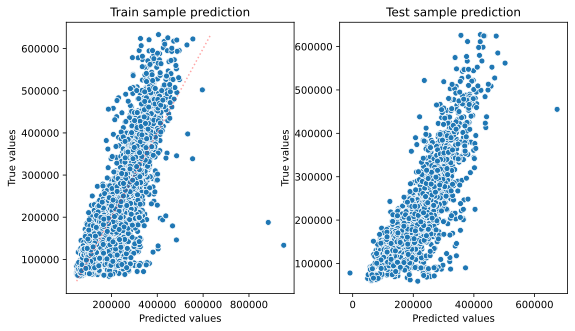

In [761]:
y_train_preds = lr.predict(X_train.fillna(-9999))

y_test_preds = lr.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

* по графику Train видно, что модель переобучена. Причем метрика МАЕ очень сильно занижена от средней величины теста и трейна
* А дельта между train R2 и test R2 <5%, но отрицательная. такая модель обучения на не подходит

убедимся в разнице между тренировчными цифрами и тестовыми

In [762]:
check_test = pd.DataFrame({'y_test':y_test,
                            'y_test_preds':y_test_preds.flatten()},
                         columns=['y_test','y_test_preds'])
check_test.head()

,y_test,y_test_preds
2037,178860.591507,201088.530230
1764,441040.663971,396413.236880
6690,216932.619017,205202.687984
8443,169489.511419,203820.909211
2090,260051.757992,283459.215178


Теперь обучем нашу модель по методу Случайный Лес

In [770]:
rf_model = RandomForestRegressor(n_estimators=100,max_depth=7,random_state = 29,criterion='mae')
rf_model.fit(X_train,y_train)

RandomForestRegressor(criterion='mae', max_depth=7, random_state=29)

построим графики и метрики

Train R2:	0.814
Test R2:	0.779
Train MAE:	24918.705
Test MAE:	26739.956
Train MSE:	1614360715.698
Test MSE:	1866554062.765
Train MEAN:	214456.099
Test MEAN:	213323.499
Delta:	4.286


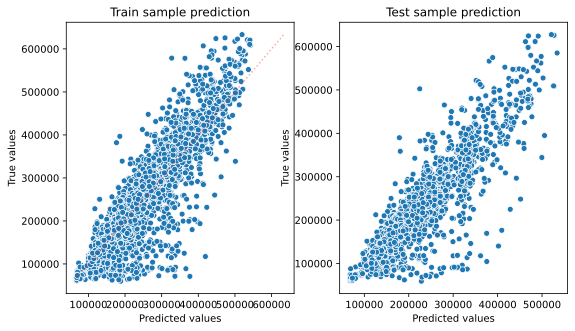

In [771]:
y_train_preds = rf_model.predict(X_train.fillna(-9999))

y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

* дельта между R2 <5%. Графики без сильного наклона, линейны
* посмотрим разницу между тестовыми значениям Таргер и тренеровчными

In [772]:
check_test = pd.DataFrame({'y_test':y_test,
                            'y_test_preds':y_test_preds.flatten()},
                         columns=['y_test','y_test_preds'])
check_test.head()

,y_test,y_test_preds
2037,178860.591507,183480.341577
1764,441040.663971,419578.841192
6690,216932.619017,215925.944998
8443,169489.511419,177279.259789
2090,260051.757992,274721.040667


посмотрим, какие атрибуты имеют значимый вес

In [773]:
features_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_),
                                       columns=['feature_name','importance'])
features_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
17,MedPricePerSqbyDist,0.344292
1,Square,0.280826
0,Rooms,0.194277
18,Mean_Sq_by_rooms,0.040149
19,Ratio_sq_mean_sq_by_rooms,0.029498
3,KitchenSquare,0.017990
9,Social_2,0.015034
20,Mean_Year_by_Dist,0.010321
8,Social_1,0.010309
21,Diff_HouseYear_and_Mean_Year,0.010286


* теперь спрогнозируем цену на выборке test.csv и запишем в файл

In [780]:
pred = full_df.loc[(full_df[target_name].isnull()),feature_names+new_feature_names]

price_preds = rf_model.predict(pred)

price_test = pd.DataFrame({'Price':price_preds.flatten()},
                         columns=['Price'])

price_test.to_csv('ASVlasov_predictions.csv')